In this notebook I will modify the workflow of [Clauset et al (2009)](https://arxiv.org/pdf/0706.1062.pdf) for fitting and interrogating a power law model to data to employ Bayesian methods. We will use the Moby data set here.

In [1]:
## Auxiliary functions
get_log_marg_lik_pwL <- function(x, m){
  ## returns the log-marginal likelihood under a power law model with a Jeffreys prior on alpha
  N <- length(x)
  logProd <- sum(log(x))
  -logProd + lgamma(N) - N * log(-(N * log(m) - logProd) )
}
source("../code/stretched_exponential_xmin.r")

## Part I: Determining the lower threshold $x_{\min}$ using orthodox methods

In [2]:
library(poweRlaw)
data(moby)
thedata <- moby
power_law_raw <- displ$new(thedata) 
raw_est <- estimate_xmin(power_law_raw)

lognorm <- dislnorm$new(thedata)
ln_est <-  estimate_xmin(lognorm)

## lower threshold under both distributions
mm_pl <- raw_est$xmin 
mm_ln <- ln_est$xmin

mm_ln;mm_pl
mmin <- mm_pl

power_law_raw$setXmin(mmin)
lognorm$setXmin(mmin)

[1] 3

[1] 7

## Part II: Fitting distributions using Stan

In [3]:
dat <- thedata[thedata > mmin]
dist.data <- list(
  N = length(dat),
  x = dat,
  x_min = mmin,
  mean_mu = 1,
  sd_mu = 5,
  a1 = 2, 
  b1 = 2,
  a2 = .1,
  b2 = .1
)

In [4]:
library(rstan)
rstan_options(auto_write = TRUE)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


In [5]:
### Power law
PL.model <- stan_model(file = "../code/stan/power_law_fixedMin_nolik.stan",
                       save_dso = TRUE)
posterior_PL  <- sampling(PL.model, data = dist.data, iter = 2000, refresh = 0)
posterior_PL

Inference for Stan model: power_law_fixedMin_nolik.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd      2.5%       25%       50%       75%     97.5%
alpha      1.90    0.00 0.02      1.86      1.89      1.90      1.91      1.93
lp__  -10826.17    0.02 0.72 -10828.17 -10826.32 -10825.89 -10825.71 -10825.66
      n_eff Rhat
alpha  1535    1
lp__   2125    1

Samples were drawn using NUTS(diag_e) at Mon Dec 17 19:13:35 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

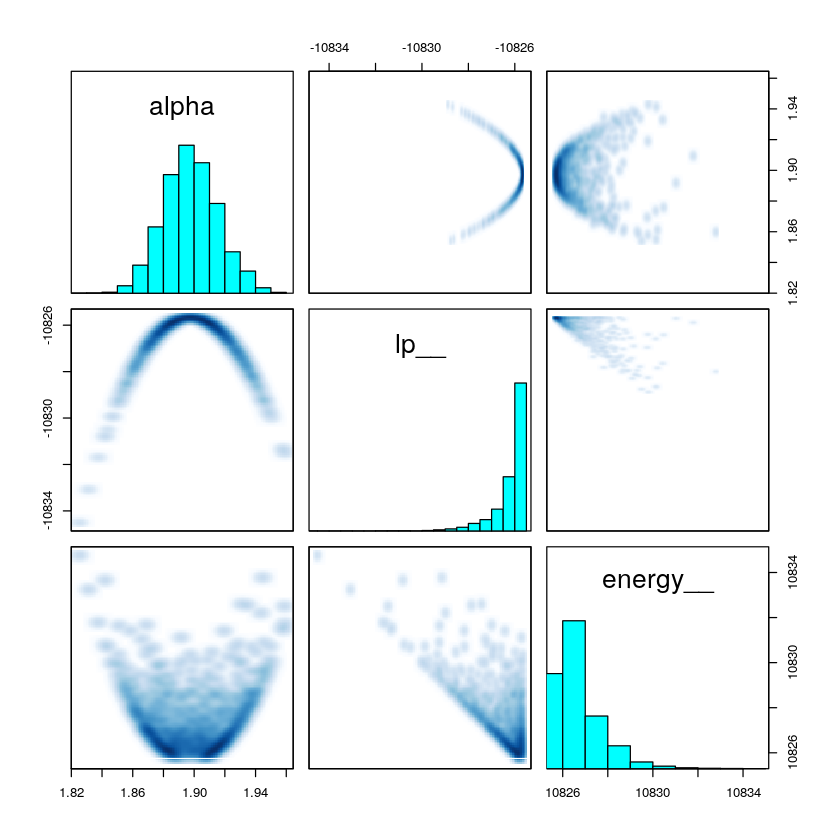

In [6]:
pairs(posterior_PL)

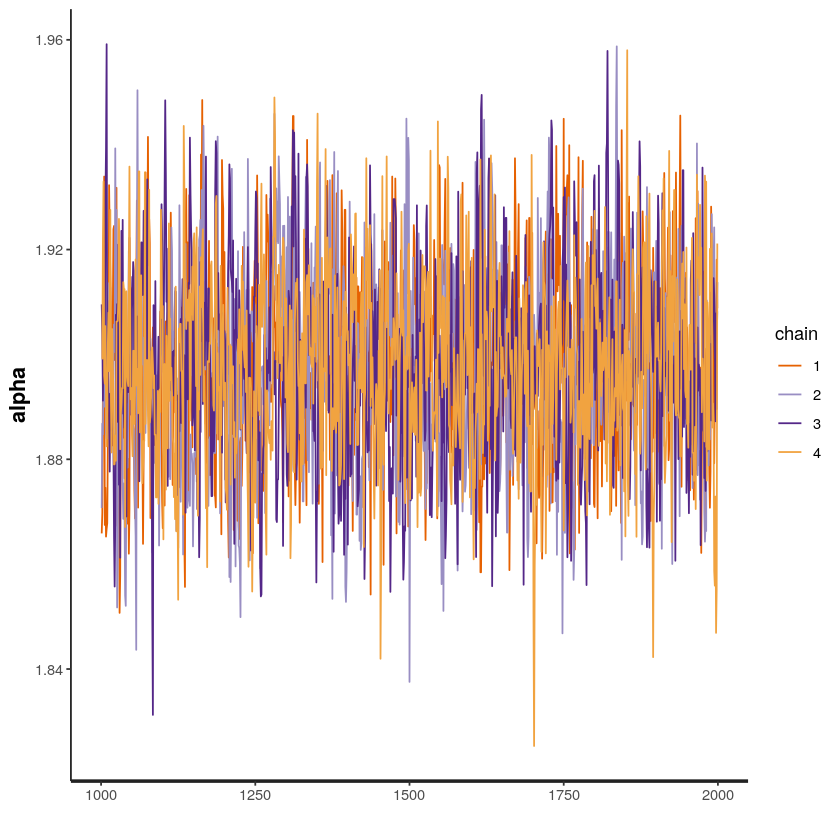

In [7]:
stan_trace(posterior_PL)

In [8]:
### Log-normal
LN.model <- stan_model(file = "../code/stan/lognormal_fixedMin.stan",
                       save_dso = TRUE)
posterior_LN  <- sampling(LN.model, data = dist.data, iter = 2000, refresh = 0)

In [9]:
posterior_LN

Inference for Stan model: lognormal_fixedMin.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd      2.5%       25%       50%       75%     97.5%
mu        -7.89    0.11 2.40    -13.49     -9.30     -7.64     -6.18     -3.95
sigma      3.63    0.02 0.37      2.99      3.38      3.61      3.86      4.44
lp__  -10829.34    0.04 1.12 -10832.48 -10829.73 -10828.99 -10828.53 -10828.27
      n_eff Rhat
mu      465 1.01
sigma   450 1.01
lp__    729 1.00

Samples were drawn using NUTS(diag_e) at Mon Dec 17 19:14:32 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

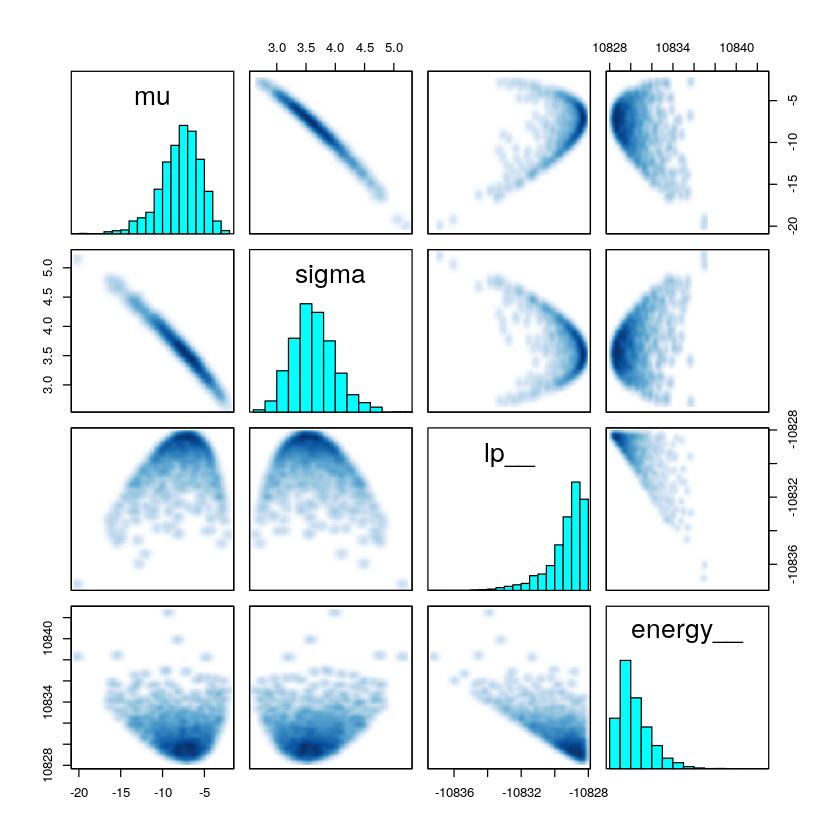

In [10]:
pairs(posterior_LN)

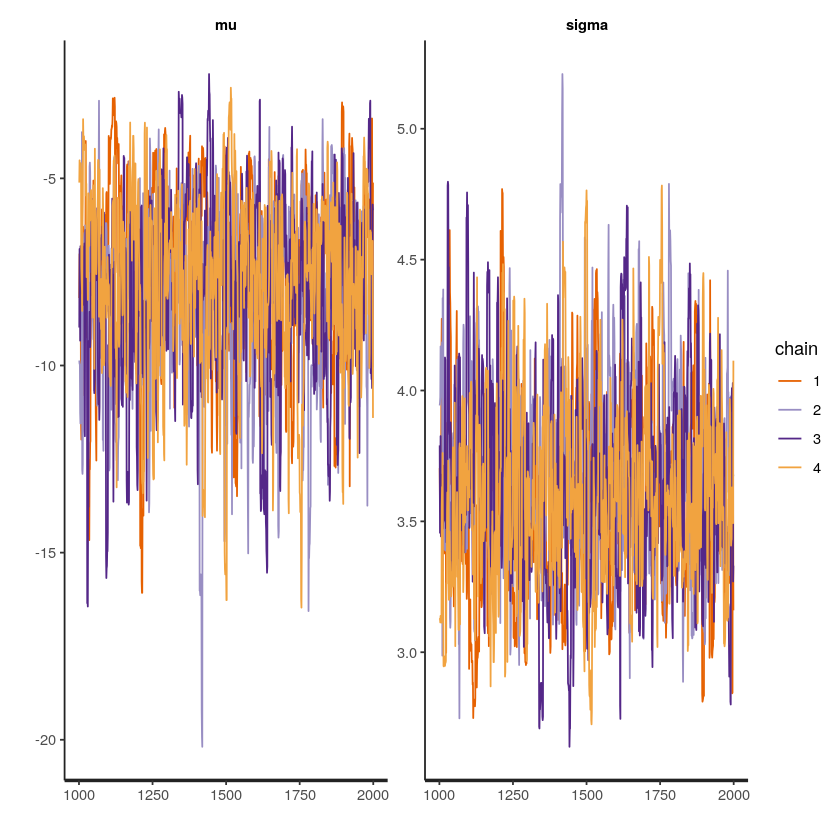

In [11]:
stan_trace(posterior_LN)

In [12]:
### Stretched exponential
ST.model <- stan_model(file = "../code/stan/stretched_exponential_fixedMin.stan",
                       save_dso = TRUE)
posterior_ST  <- sampling(ST.model, data = dist.data, iter = 2000, refresh = 0)

In [13]:
posterior_ST

Inference for Stan model: stretched_exponential_fixedMin.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean   sd      2.5%       25%       50%       75%     97.5%
beta        0.07    0.00 0.02      0.04      0.05      0.06      0.08      0.10
lambda     12.14    0.18 3.85      6.73      9.46     11.48     14.08     21.66
lp__   -10830.43    0.04 1.05 -10833.23 -10830.85 -10830.11 -10829.68 -10829.41
       n_eff Rhat
beta     430 1.01
lambda   477 1.01
lp__     764 1.00

Samples were drawn using NUTS(diag_e) at Mon Dec 17 19:19:42 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

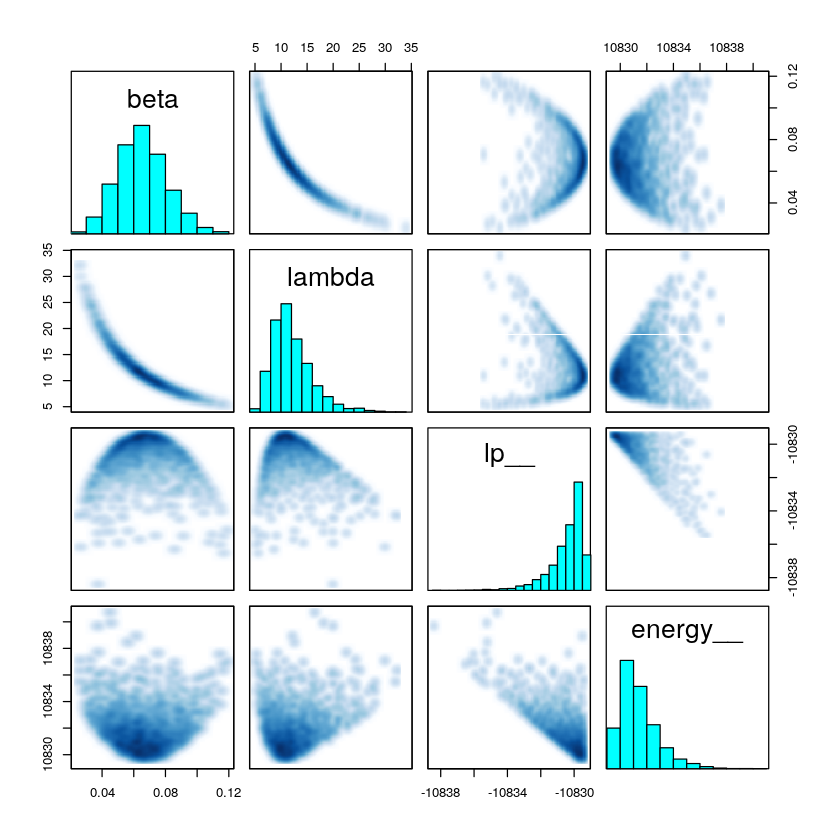

In [14]:
pairs(posterior_ST)

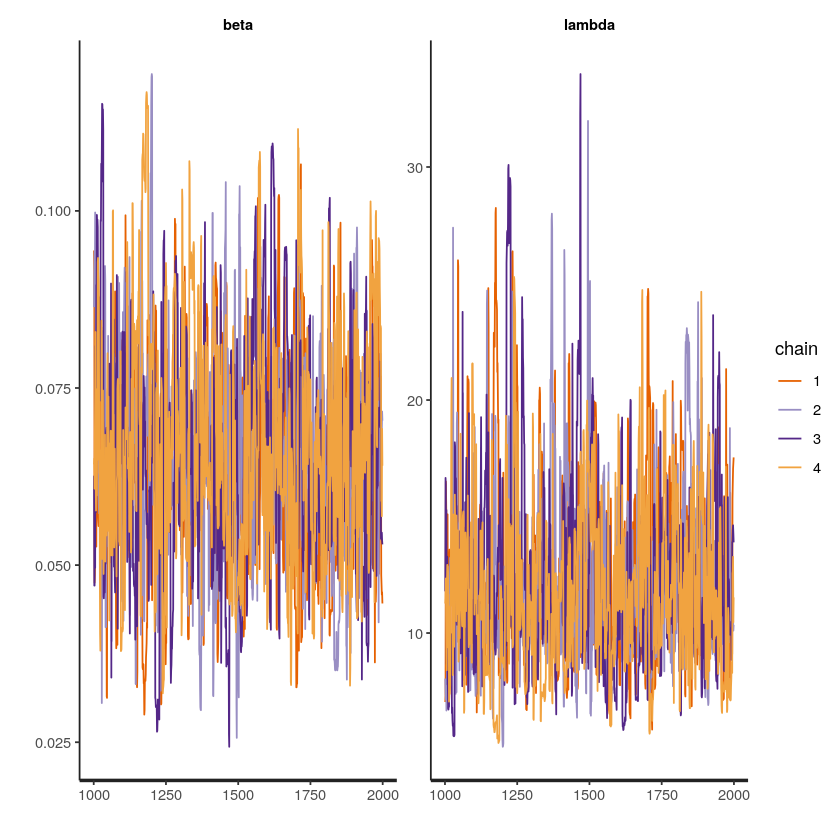

In [15]:
stan_trace(posterior_ST)

#### Marginal likelihood estimation and (log) Bayes factors

In [16]:
## Marginal likelihoods
library(bridgesampling)
summary( mal_est_LN  <- bridgesampling::bridge_sampler(posterior_LN) )
summary( mal_est_ST  <- bridgesampling::bridge_sampler(posterior_ST) )
(mal_pwL <- get_log_marg_lik_pwL(dist.data$x, dist.data$x_min) )

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


Logml_Estimate,Relative_Mean_Squared_Error,Coefficient_of_Variation,Percentage_Error,Method,Repetitions
-10830.21,0.0002284098,0.01511323,1.51%,normal,1


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


Logml_Estimate,Relative_Mean_Squared_Error,Coefficient_of_Variation,Percentage_Error,Method,Repetitions
-10832.93,3.780239e-05,0.006148365,0.615%,normal,1


[1] -10828.67

In [17]:
### log Bayes factor log-normal vs power law
(logBF_LN <- mal_est_LN$logml - mal_pwL )

[1] -1.540025

In [18]:
### log Bayes factor Stretched exponential vs power law
(logBF_ST <- mal_est_ST$logml - mal_pwL )

[1] -4.257068

In [19]:
### log Bayes factor Stretched exponential vs log-normal
(logBF_ST <- mal_est_ST$logml - mal_est_LN$logml  )

[1] -2.717043

**conclusion**: power-law is the best model amongst the set tested. This is in mild disagreement with the analyses by Collin Gillespie  [here](https://cran.r-project.org/web/packages/poweRlaw/vignettes/b_powerlaw_examples.pdf). (Section 1.3)

In [20]:
get_marginal_likelihood_str_expo <- function(x, a1 = 1, b1 = 1, a2 = 2, b2 = 2, xmin = 0){
  N <- length(x)
  sumLog <- sum(log(x))
  lconst_par <- ( a1*log(b1) - lgamma(a1) ) + ( a2*log(b2) - lgamma(a2) )
  lconst_p <- -sumLog
  lconst_N <- lgamma(N + a2)
  fb <- function(bb, args){
    dummy <- args[1] + args[2]
    lSb <-  log_sum_exp(bb * log(x))
    ld <- (N + a1 - 1)*log(bb) - (b1 - sumLog)*bb - (N + a2) * log_diff_exp(log_sum_exp(c(lSb, log(b2))), log(N) + bb * log(xmin))
    return(dummy * ld)
  }
  fb <- Vectorize(fb)
  require(reticulate)
  lint <- import("lintegrate", convert = FALSE)
  intt <- lint$lcquad(py_func(fb), a=r_to_py(0), b=r_to_py(1), ## increasing this bound will actually DECREASE accuracy
                      args=c(1, 0), epsabs = r_to_py(1e-30))
  res <- reticulate::py_to_r(intt[0])
  return(list(logml  = lconst_par + lconst_N + lconst_p + res, 
              otherstuff = intt ))
}
mal_stexpo <- get_marginal_likelihood_str_expo(x = dist.data$x, xmin = dist.data$x_min,
                                                a1 = dist.data$a1,
                                                b1 = dist.data$b1,
                                                a2 = dist.data$a2,
                                                b2 = dist.data$b2)
mal_est_ST$logml
mal_stexpo

[1] -10832.93

$logml
[1] -10832.92

$otherstuff
(-20703.014522900652, -10349.831205425748, 33)


### Plotting

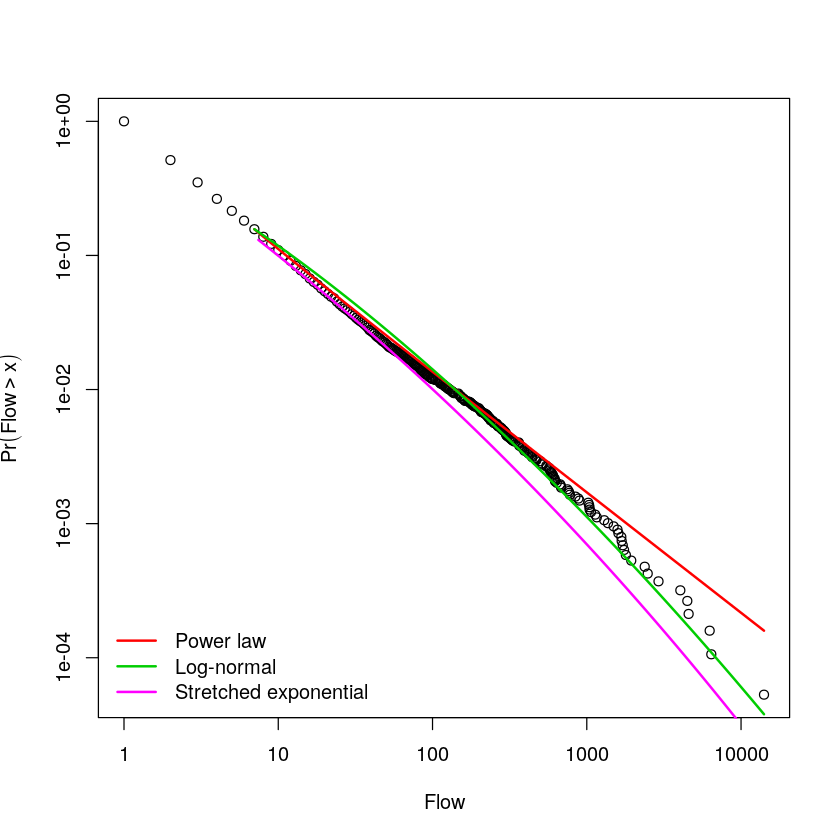

In [21]:
alpha.hat <- summary(posterior_PL)$summary[1, 1]
mu.hat <- summary(posterior_LN)$summary[1, 1]
sigma.hat <- summary(posterior_LN)$summary[2, 1]
beta.hat <- summary(posterior_ST)$summary[1, 1]
lambda.hat <- summary(posterior_ST)$summary[2, 1]
##
power_law_raw$setPars(raw_est$pars)
lognorm$setPars(c(mu.hat, sigma.hat))
cfactor <- mean(power_law_raw$dat > power_law_raw$getXmin()) ## correction factor
#
plot(power_law_raw, xlab = "Flow", ylab = expression(Pr(Flow > x)))
power_law_raw$setPars(alpha.hat)
lines(power_law_raw, col = 2, lwd  = 2)
lines(lognorm, col = 3, lwd = 2)
curve(stexpo_xmin_cdf(x, beta.hat, lambda.hat, dist.data$x_min) * cfactor,
      1, max(dist.data$x), col = 6, lwd = 2, add = TRUE)
legend(x = "bottomleft",
       legend = c("Power law", "Log-normal", "Stretched exponential"),
       col = c(2, 3, 6), lwd = 2, bty = 'n')